# Hudi + Lance Demo: Intelligent Recruitment Platform
**(Hybrid Search + Analytics on the Lakehouse)**

One table. Three query patterns. Zero data copying.

1. Load real job postings from HuggingFace
2. Ingest into a Hudi table with Lance vector embeddings
3. **Vector Search** — match a resume by meaning
4. **Hybrid Search** — add business constraints (SQL + vectors)
5. **Analytics** — executive dashboard on the same data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from datasets import load_dataset
import shutil, os, sys
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

TABLE_PATH = "/tmp/hudi_recruiting_lake_nopart"
TABLE_NAME = "job_market_nopart"
EMBEDDING_MODEL = "all-MiniLM-L6-v2"

# Spark/Lance emit log lines with surrogate characters that break
# Jupyter's JSON serializer. Wrap both streams to sanitize them.
class _SafeStream:
    def __init__(self, stream):
        self._stream = stream
    def write(self, s):
        return self._stream.write(s.encode("utf-8", errors="replace").decode("utf-8"))
    def flush(self):
        return self._stream.flush()
    def __getattr__(self, name):
        return getattr(self._stream, name)

sys.stdout = _SafeStream(sys.stdout)
sys.stderr = _SafeStream(sys.stderr)

## 1. Start Spark with Hudi + Lance

In [2]:
spark = (SparkSession.builder.appName("Recruiting-Lakehouse")
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .config("spark.sql.extensions", "org.apache.spark.sql.hudi.HoodieSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.hudi.catalog.HoodieCatalog")
    .config("spark.driver.memory", "4g")
    .config("spark.ui.showConsoleProgress", "false")
    .getOrCreate())

spark.sparkContext.setLogLevel("ERROR")

print(f"\u2713 Spark {spark.version} ready with Hudi extensions.")

26/02/17 19:31:58 WARN Utils: Your hostname, Andys-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.125.118.203 instead (on interface en0)
26/02/17 19:31:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/02/17 19:31:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


✓ Spark 3.5.3 ready with Hudi extensions.


## 2. Load Real Job Postings from HuggingFace

~3k data science job descriptions from [nathansutton/data-science-job-descriptions](https://huggingface.co/datasets/nathansutton/data-science-job-descriptions).

In [3]:
ds = load_dataset("nathansutton/data-science-job-descriptions", split="train")

jobs_data = []
for i, row in enumerate(ds):
    jobs_data.append({
        "job_id": f"job_{i:04d}",
        "company": row["company"],
        "title": row["title"],
        "job_description": row["job_description"],
        "text_for_vector": f"{row['title']} {row['job_description']}"
    })

companies = set(r["company"] for r in jobs_data)
print(f"\u2713 Loaded {len(jobs_data)} job postings from {len(companies)} companies.\n")

preview = pd.DataFrame(jobs_data, columns=["job_id", "company", "title", "job_description"])
preview["job_description"] = preview["job_description"].str[:80] + "..."
preview.head(10)

Repo card metadata block was not found. Setting CardData to empty.


✓ Loaded 2921 job postings from 969 companies.



,job_id,company,title,job_description
0,job_0000,Altoida,Data Science Director,\n\n\n\nAltoida is a pioneer in developing dig...
1,job_0001,Veeva Systems,Senior Data Scientist,\n\n\nVeeva Systems is a mission-driven organi...
2,job_0002,Slack,Staff Data Scientist,"\nTo get the best candidate experience, please..."
3,job_0003,Pinterest,Sr Staff Data Scientist Ecosystem,\n\nAbout Pinterest:\nMillions of people acros...
4,job_0004,Pinterest,Staff Data Scientist Growth,\n\nAbout Pinterest:\nMillions of people acros...
5,job_0005,Pinterest,Staff Data Scientist Browse Discovery,\n\nAbout Pinterest:\nMillions of people acros...
6,job_0006,Pinterest,Sr Data Scientist Search,\n\nAbout Pinterest:\nMillions of people acros...
7,job_0007,Pinterest,Sr Data Scientist Growth,\n\nAbout Pinterest:\nMillions of people acros...
8,job_0008,Proofpoint,Senior Data Scientist,\nIt's fun to work in a company where people t...
9,job_0009,Comcast,Lead Data Scientist,\n\nJob Summary\nThe Data Science team builds ...


## 3. Embed & Ingest into the Lakehouse

We embed every job description into a 384-dim vector, then write structured fields **and** embeddings into a single Hudi table using the Lance file format.

In [4]:
model = SentenceTransformer(EMBEDDING_MODEL)
embeddings = model.encode([r["text_for_vector"] for r in jobs_data], show_progress_bar=True)

for i, row in enumerate(jobs_data):
    row["embedding"] = embeddings[i].tolist()

print(f"\u2713 Generated {len(embeddings)} embeddings (dim={len(embeddings[0])}).")
print(f"  Each embedding is built from: title + job_description\n")

preview = pd.DataFrame(jobs_data, columns=["job_id", "title", "job_description", "embedding"])
preview["job_description"] = preview["job_description"].str[:60] + "..."
preview["embedding"] = preview["embedding"].apply(lambda v: str(v[:3])[:-1] + ", ...]")
preview.head(10)

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

✓ Generated 2921 embeddings (dim=384).
  Each embedding is built from: title + job_description



,job_id,title,job_description,embedding
0,job_0000,Data Science Director,\n\n\n\nAltoida is a pioneer in developing dig...,"[-0.030186746269464493, -0.07726149260997772, ..."
1,job_0001,Senior Data Scientist,\n\n\nVeeva Systems is a mission-driven organi...,"[-0.07847969979047775, -0.023534078150987625, ..."
2,job_0002,Staff Data Scientist,"\nTo get the best candidate experience, please...","[-0.024468308314681053, -0.06033605337142944, ..."
3,job_0003,Sr Staff Data Scientist Ecosystem,\n\nAbout Pinterest:\nMillions of people acros...,"[-0.017895415425300598, -0.13528017699718475, ..."
4,job_0004,Staff Data Scientist Growth,\n\nAbout Pinterest:\nMillions of people acros...,"[-0.021268101409077644, -0.14506541192531586, ..."
5,job_0005,Staff Data Scientist Browse Discovery,\n\nAbout Pinterest:\nMillions of people acros...,"[-0.041841521859169006, -0.14577853679656982, ..."
6,job_0006,Sr Data Scientist Search,\n\nAbout Pinterest:\nMillions of people acros...,"[-0.04083168879151344, -0.12358294427394867, 0..."
7,job_0007,Sr Data Scientist Growth,\n\nAbout Pinterest:\nMillions of people acros...,"[-0.02691471204161644, -0.11413008719682693, 0..."
8,job_0008,Senior Data Scientist,\nIt's fun to work in a company where people t...,"[-0.07257407158613205, -0.014052029699087143, ..."
9,job_0009,Lead Data Scientist,\n\nJob Summary\nThe Data Science team builds ...,"[-0.0638699010014534, -0.058765701949596405, 0..."


In [5]:
schema = StructType([
    StructField("job_id", StringType(), False),
    StructField("company", StringType(), False),
    StructField("title", StringType(), False),
    StructField("job_description", StringType(), False),
    StructField("text_for_vector", StringType(), False),
    StructField("embedding", ArrayType(FloatType()), False),
])

if os.path.exists(TABLE_PATH):
    shutil.rmtree(TABLE_PATH)

df = spark.createDataFrame(jobs_data, schema=schema)

hudi_options = {
    "hoodie.table.name": TABLE_NAME,
    "hoodie.datasource.write.recordkey.field": "job_id",
    "hoodie.datasource.write.partitionpath.field": "",
    "hoodie.datasource.write.keygenerator.class": "org.apache.hudi.keygen.NonpartitionedKeyGenerator",
    "hoodie.datasource.write.table.type": "COPY_ON_WRITE",
    "hoodie.datasource.write.operation": "upsert",
    "hoodie.table.base.file.format": "lance",
    "hoodie.write.record.merge.custom.implementation.classes": "org.apache.hudi.DefaultSparkRecordMerger"
}

df.write.format("hudi").options(**hudi_options).mode("overwrite").save(TABLE_PATH)
print(f"\u2713 Ingested {len(jobs_data)} jobs into Hudi table at {TABLE_PATH}")

[2026-02-18T00:32:53Z WARN  lance_file::v2::writer] You have requested an unstable format version.  Files written with this format version may not be readable in the future!  This is a development feature and should only be used for experimentation and never for production data.


# WARNING: Unable to get Instrumentation. Dynamic Attach failed. You may add this JAR as -javaagent manually, or supply -Djdk.attach.allowAttachSelf
# WARNING: Unable to attach Serviceability Agent. Unable to attach even with module exceptions: [org.apache.hudi.org.openjdk.jol.vm.sa.SASupportException: Sense failed., org.apache.hudi.org.openjdk.jol.vm.sa.SASupportException: Sense failed., org.apache.hudi.org.openjdk.jol.vm.sa.SASupportException: Sense failed.]
✓ Ingested 2921 jobs into Hudi table at /tmp/hudi_recruiting_lake_nopart


---
## 4. Vector Search — "Upload" a Resume

A candidate uploads their resume. They have experience in **product growth, A/B testing, and experimentation** — but the resume never uses the exact job title *"Data Scientist Growth."* Can the system find the right roles anyway?

In [6]:
resume_text = """
EXPERIENCE:
- 4 years driving product growth through data science and experimentation.
- Built A/B testing frameworks and analyzed user funnels to optimize conversion.
- Led causal inference studies measuring the impact of new product features.
- Python, SQL, Bayesian statistics, and machine learning for growth modeling.
"""

print(f"\U0001F4C4 Resume Uploaded:\n{resume_text.strip()}")

📄 Resume Uploaded:
EXPERIENCE:
- 4 years driving product growth through data science and experimentation.
- Built A/B testing frameworks and analyzed user funnels to optimize conversion.
- Led causal inference studies measuring the impact of new product features.
- Python, SQL, Bayesian statistics, and machine learning for growth modeling.


In [7]:
resume_vector = model.encode([resume_text])[0].tolist()
spark.createDataFrame([(resume_vector,)], ["q_vec"]).createOrReplaceTempView("query_input")

# Read the full table for joining (vector search can misalign non-vector columns)
spark.read.format("hudi").load(TABLE_PATH).createOrReplaceTempView("jobs_table")

matches_df = spark.sql(f"""
    SELECT j.title, j.company, j.job_description, round(1 - v._distance, 2) as score
    FROM hudi_vector_search(
        '{TABLE_PATH}', 'embedding', (SELECT q_vec FROM query_input), 10, 'cosine'
    ) v
    JOIN jobs_table j ON v.job_id = j.job_id
""").toPandas()

matches_df["job_description"] = matches_df["job_description"].str.strip().str[:100] + "..."

print("\U0001F50E Top Semantic Matches:\n")
matches_df

🔎 Top Semantic Matches:



,title,company,job_description,score
0,Lead Data Scientist,Growthbook,About GrowthBookHere at GrowthBook we are buil...,0.61
1,Growth Scientist Woocommerce,Automattic,Growth Scientists at WooCommerce sit at the in...,0.60
2,Principal Data Scientist Cnet Group,Red Ventures,We are seeking a highly skilled Principal Data...,0.56
3,Data Scientist I Product Analytics,Bold,...,0.55
4,Senior Data Scientist Decision Engine,Perchhq,We are looking for a Data Scientist to build o...,0.55
5,Senior Data Scientist Decision Engine,Perchhq,We are looking for a Data Scientist to build o...,0.55
6,Lead Data Scientist Product Growth,Loom,The Role\nWe’re looking to add a Lead Data Sci...,0.55
7,Senior Data Scientist Product Growth,Hopper,About the job\n\nWe’re looking for a Senior Da...,0.54
8,Principal Data Scientist New Product Development,Mission Lane,About the role:\nWe’re looking for an experien...,0.54
9,Data Scientist Entry Level,Revenue Analytics,Are you curious about applying analytics to bu...,0.53


The resume never mentions *"Data Scientist"* or *"Growth"* as a job title — but vector search finds growth-focused roles by **meaning**, not keywords.

---
## 5. Hybrid Search — Add Business Constraints

The candidate says: *"I specifically want to work at Reddit."*

We combine the **same vector search** with a standard SQL `WHERE` clause. Vector + SQL in one query.

In [8]:
# Post-filter approach: fetch a wide vector search window, then apply SQL filters.
# hudi_vector_search() operates on the full vector index and doesn't yet support
# predicate pushdown — so we retrieve broadly and filter after.
# Future optimization: push filters directly into the vector index scan.

hybrid_df = spark.sql(f"""
    SELECT j.title, j.company, j.job_description, round(1 - v._distance, 2) as score
    FROM hudi_vector_search(
        '{TABLE_PATH}', 'embedding', (SELECT q_vec FROM query_input), 3000, 'cosine'
    ) v
    JOIN jobs_table j ON v.job_id = j.job_id
    WHERE j.company = 'Reddit'
    ORDER BY score DESC
    LIMIT 5
""").toPandas()

hybrid_df["job_description"] = hybrid_df["job_description"].str.strip().str[:100] + "..."

print("\U0001F50E Hybrid Matches (Reddit only):\n")
hybrid_df

🔎 Hybrid Matches (Reddit only):



,title,company,job_description,score
0,Data Scientist Analytics Ads Measurement,Reddit,We are looking for a Data Scientist to work wi...,0.48
1,Sr Data Scientist Analytics Ads Measurement,Reddit,We are looking for a Senior Data Scientist to ...,0.47
2,Sr Data Scientist Analytics Growth Retention,Reddit,We are looking for a results-oriented and stra...,0.46
3,Senior Data Scientist Ads Analytics,Reddit,We are looking for a Data Scientist to work wi...,0.46
4,Data Scientist Machine Learning Ads Planning O...,Reddit,We are looking for a Machine Learning Data Sci...,0.45


Same Hudi table. Same vector index. Just added a SQL filter.

---
## 6. Analytics Dashboard

Now we switch hats — we're an analyst on the job platform team. Which companies are hiring the most? What roles dominate the market? We query the **exact same table**. No ETL to a separate warehouse.

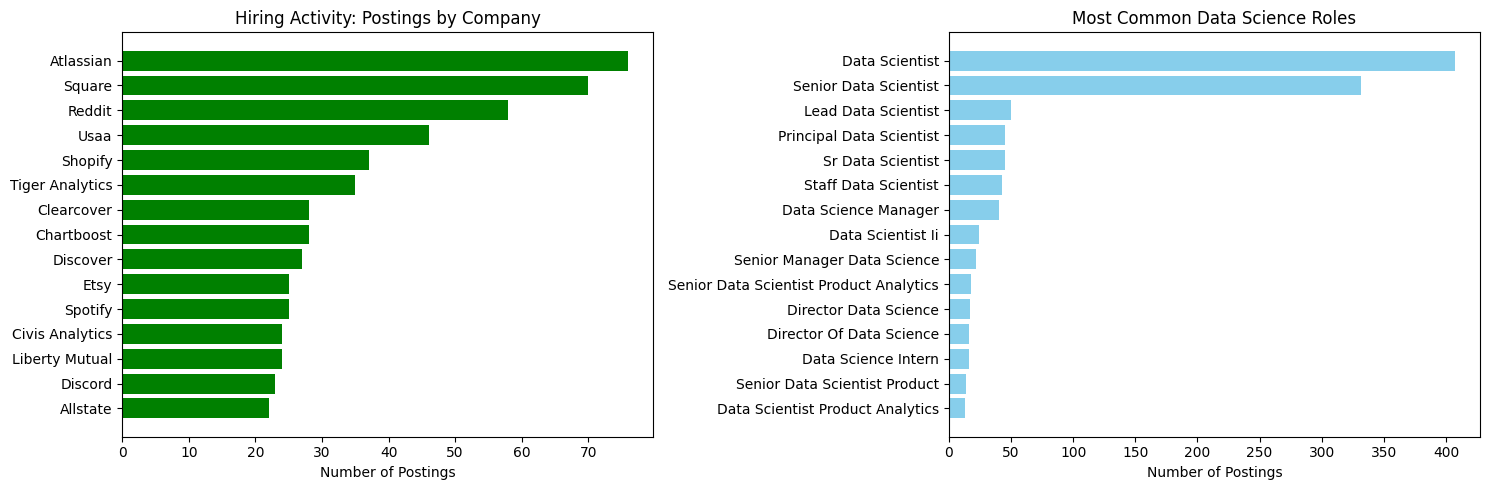

✓ Dashboard generated from the same Hudi table.


In [9]:
# Reuse the jobs_table view loaded from the same Hudi table in cell 11.
# Filter on job_id to exclude any Hudi metadata partition rows.

company_df = spark.sql("""
    SELECT company, count(*) as job_count
    FROM jobs_table
    WHERE job_id LIKE 'job_%'
    GROUP BY company
    ORDER BY job_count DESC LIMIT 15
""").toPandas()

title_df = spark.sql("""
    SELECT title, count(*) as title_count
    FROM jobs_table
    WHERE job_id LIKE 'job_%' AND title IS NOT NULL
    GROUP BY title
    ORDER BY title_count DESC LIMIT 15
""").toPandas()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].barh(company_df["company"], company_df["job_count"], color="green")
axes[0].set_title("Hiring Activity: Postings by Company")
axes[0].set_xlabel("Number of Postings")
axes[0].invert_yaxis()

axes[1].barh(title_df["title"], title_df["title_count"], color="skyblue")
axes[1].set_title("Most Common Data Science Roles")
axes[1].set_xlabel("Number of Postings")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\u2713 Dashboard generated from the same Hudi table.")

---
**One table. Vector search, hybrid search, and analytics. No data copying, no separate vector database.**

In [ ]:
spark.stop()